In [1]:
from tqdm import tqdm
import pandas as pd
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
api = wandb.Api()

# Pull and Dedup Data

In [2]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    # "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [3]:
# Composable_Interventions has all the results
project_paths = [
    'dri-ice/Composable_Interventions',
    # 'dri-ice/AK_Tests'
]

filter_dict = { "state": "finished" }
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    
    # Iterate over eachrun and capture the c        onfig and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-07-30 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True
            
            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")

# Sort by 'tag' and '_timestamp' in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=['tag', '_timestamp'], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit='s')
all_runs_df_sorted = all_runs_df.sort_values(by=['_timestamp'], ascending=[False])
all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["qa_question_count_limit"].isnull()]

dri-ice/Composable_Interventions:  47%|████▋     | 2101/4471 [00:11<00:11, 207.18it/s]

Error processing run evuxnltk: '_timestamp'
Error processing run mje2wvj7: '_timestamp'
Error processing run um0dxn3y: '_timestamp'
Error processing run isna6rgu: '_timestamp'
Error processing run luhstpn5: '_timestamp'
Error processing run lrh5z3wp: '_timestamp'
Error processing run 2do500pc: '_timestamp'


dri-ice/Composable_Interventions:  48%|████▊     | 2151/4471 [00:11<00:11, 197.40it/s]

Error processing run 71jdht68: '_timestamp'
Error processing run 64ed5z4t: '_timestamp'
Error processing run 1wj0u6cj: '_timestamp'
Error processing run cc3cmdlj: '_timestamp'
Error processing run 7t3n8sq1: '_timestamp'
Error processing run o1ai36xl: '_timestamp'
Error processing run 31j4yjsr: '_timestamp'
Error processing run 2nv88i8v: '_timestamp'
Error processing run sdhehb2z: '_timestamp'
Error processing run r6kpsu09: '_timestamp'
Error processing run arid375k: '_timestamp'


dri-ice/Composable_Interventions: 100%|█████████▉| 4451/4471 [00:25<00:00, 178.68it/s]

Error processing run n0iel6ok: '_timestamp'
Error processing run xr5mede5: '_timestamp'
Error processing run 27f8pxs0: '_timestamp'


dri-ice/Composable_Interventions: 100%|██████████| 4471/4471 [00:25<00:00, 177.09it/s]
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/2829184290.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]


In [4]:
all_runs_df_sorted["unlearn"].value_counts()

unlearn
none    2434
rmu      577
ga       249
gd       190
Name: count, dtype: int64

In [5]:
# TODO: Ensure that rmu_layer_id is 3. This was originaly set to 5, but decided to rerun the evals last minute with a better hyperparameter.
# Use older RMU experiments
# all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["rmu_layer_id"] != 3]

In [6]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset="tag", keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "LoRA",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
    "ga": "GA",
    "gd": "GD",
}
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics
display(all_runs_df_deduplicated.value_counts("tag"))
print(f"Number of experiments: {len(all_runs_df_deduplicated)}")

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/923748476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/923748476.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000

tag
AWQ2bit-to-ft             1
lora-to-AWQ8bit           1
lora-to-SparseGPT0.45%    1
lora-to-SparseGPT0.35%    1
lora-to-SparseGPT0.25%    1
                         ..
awq6bit-rmu               1
awq6bit-gd                1
awq6bit-ga                1
awq5bit-rmu               1
wanda0.75\%-rmu           1
Name: count, Length: 311, dtype: int64

Number of experiments: 311


In [7]:
# TODO: Get a second pair of eyes on this this math

# Math for determining number of interventions
awq_settings = 6
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

69
50


In [8]:
all_runs_df_deduplicated["unlearn"].value_counts()

unlearn
GA     51
GD     51
RMU    51
Name: count, dtype: int64

In [9]:
data = all_runs_df_deduplicated

categories = {
    "No Intervention": data[data["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": data[data["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": data[data["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": data[data["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": data[data["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": data[data["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": data[data["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": data[data["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": data[data["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": data[data["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

# assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

assert len(categories["Compression to Edit"]) == (editor_count // 2 )- 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 3, f"{len(categories['Unlearn'])} != 3"
assert len(categories["Edit to Unlearn"]) == 9, f"{len(categories['Edit to Unlearn'])} != 3"
assert len(categories["Unlearn to Edit"]) == 9, f"{len(categories['Unlearn to Edit'])} != 3"

# display(categories["Compress to Unlearn"])
# assert len(categories["Compress to Unlearn"]) == rmu_count // 2, f"{len(categories['Compress to Unlearn'])} != {rmu_count // 2}"

# display(categories["Unlearn to Compress"])
# assert len(categories["Unlearn to Compress"]) == rmu_count // 2, f"{len(categories['Unlearn to Compress'])} != {rmu_count // 2}"


# Create Results Tables

# Create Plots

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font family to serif
plt.rcParams["font.family"] = "serif"

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")

# plotting constants
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 12
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 3
MARKER_SIZE = 8
X_LABEL_ROTATION = 20

# Set colors for compositons with compression
colors = {"Wanda": "C1", "SparseGPT": "C2", "AWQ": "C3", "GPTQ": "C4"}

## Plot: Composability Heatmaps

In [11]:
intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "LoRA": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn"
}
default_value = None

mmlu_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]
        
        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_heatmap_data[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_heatmap_data[first_intervention][second_intervention] = avg_wmdp_diff
        
        rewrite_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_heatmap_data[first_intervention][second_intervention] = rewrite_diff
        
# print("MMLU")
# display(mmlu_heatmap_data)

# print("WMDP")
# display(wmdp_heatmap_data)

# print("Rewrite")
# display(rewrite_heatmap_data)

KeyError: 'GA'

In [ ]:
# Create three heatmaps next two eachother, one for each frame
fig, axes = plt.subplots(1, 3, figsize=(6 * FIG_SIZE, 2 * FIG_SIZE))
y_labels = {
    0: "MMLU Acc",
    1: "WMDP Acc",
    2: "Edit Success"
}

sns.heatmap(mmlu_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[0], cbar=False)
sns.heatmap(wmdp_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[1], cbar=False)
sns.heatmap(rewrite_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[2], cbar=False)

# roate x labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=X_LABEL_ROTATION)

for i, ax in enumerate(axes):
    ax.set_ylabel(y_labels[i], fontsize=TITLE_FONT_SIZE)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

if not os.path.exists("figures"):
    os.makedirs("figures")

plt.savefig("figures/delta_heatmaps.pdf", bbox_inches="tight")

## Plot: Editing under Compression 

In [16]:
def get_order_label(row):
    interventions = row["interventions"]
    first_method = ""
    second_method = ""
    if interventions[0] == "edit":
        first_method = row["edit"]
    elif interventions[0] == "compress":
        first_method = row["compression"]
    elif interventions[0] == "unlearn":
        first_method = row["unlearn"]
    
    if interventions[1] == "edit":
        second_method = row["edit"]
    elif interventions[1] == "compress":
        second_method = row["compression"]
    elif interventions[1] == "unlearn":
        second_method = row["unlearn"]
    
    return f"{first_method}→{second_method}"

def wrap_label(interventions):
    first_intervention, second_intervention = interventions[0], interventions[1]
    first_letter_upper = first_intervention[0].upper()
    second_letter_upper = second_intervention[0].upper()
    
    # EX: E $\rightarrow$ C
    return f"{first_letter_upper}$\\rightarrow${second_letter_upper}"


### Create mock records for baselines

In [17]:
# I want instances where editing has been applied but there is no unlearning or compression. In these cases, set wbits=16 and sparsity=0 
baseline_editors = data[(data["edit"].notnull()) & (data["unlearn"].isnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["edit"]))].copy()
baseline_editors["wbits"] = 16
baseline_editors["sparsity_ratio"] = 0
news_records = []

# Edit and Compress
for editing_method in ["LoRA", "MEMIT", "Fine-tune"]:
    baseline_record = baseline_editors[baseline_editors["edit"] == editing_method]
    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        edit_first_record = baseline_record.copy()
        edit_first_record["compression"] = compression_method
        edit_first_record["interventions"] = [["edit", "compress"]]
        news_records.append(edit_first_record)

        compress_first_record = baseline_record.copy()
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "edit"]]
        news_records.append(compress_first_record)

baseline_unlearners = data[(data["edit"].isnull()) & (data["unlearn"].notnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["unlearn"]))].copy()

# Compress and Unlearn
for unlearn_method in ["RMU", "GA", "GD"]:
    baseline_record = baseline_unlearners[baseline_unlearners["unlearn"] == unlearn_method]

    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        compress_first_record = baseline_record.copy()
        compress_first_record["unlearn"] = unlearn_method
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "unlearn"]]
        news_records.append(compress_first_record)

        unlearn_first_record = baseline_record.copy()
        unlearn_first_record["unlearn"] = unlearn_method
        unlearn_first_record["compression"] = compression_method
        unlearn_first_record["interventions"] = [["unlearn", "compress"]]
        news_records.append(unlearn_first_record)

baseline_records = pd.concat(news_records)

### Combined Pruning and Quantization

In [18]:
# Add mock baseline records to the frame used for plotting
data = pd.concat([data, baseline_records])

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/533696548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/533696548.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_line["label"] = first_line["order"].apply(wrap_label)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/533696548.py:49: SettingWithCopyWarning: 
A value is trying to

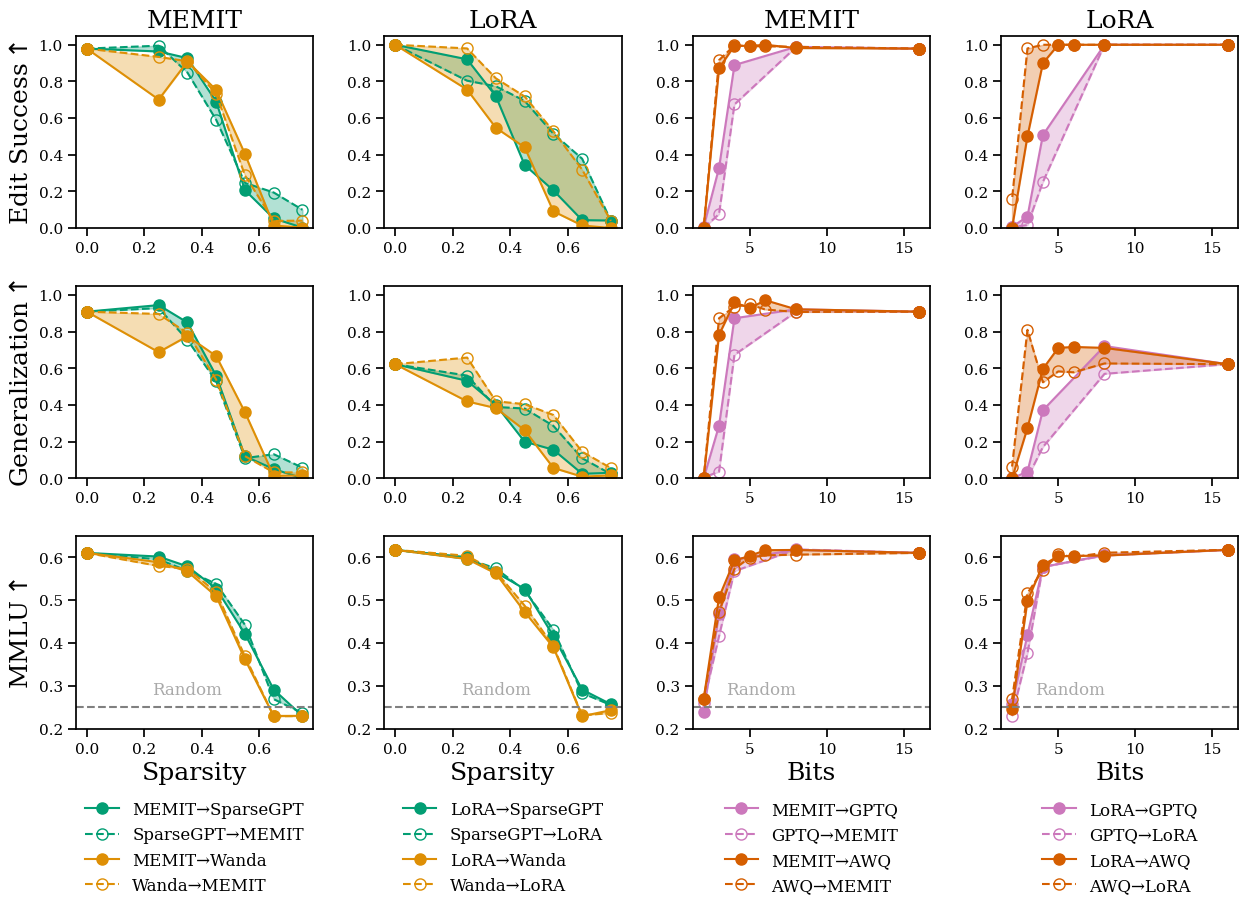

In [19]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
# pruning_frame = pruning_frame[pruning_frame["edit"] != "Fine-tune"]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame = quantization_frame[quantization_frame["edit"] != "Fine-tune"]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

# 4 columns and 3 rows
fig, axes = plt.subplots(3, 4, figsize=(5 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "MEMIT",
    3: "LoRA",
}

compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # MEMIT and GPTQ + AWQ
    2: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    3: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 2 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "Fine-tune"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if row_index != 2:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")
            if col_index < 2:
                ax.text(0.35, 0.28, "Random", color="darkgray", ha="center")
            else:
                ax.text(8, 0.28, "Random", color="darkgray", ha="right")

        if row_index == 0:
            title = column_edit_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 2:
            ax.set_xlabel("Sparsity" if col_index < 2 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 2:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression.pdf", bbox_inches="tight")

### 3 X 3 for Pruning and Quantization (Two Plots)

In [20]:
compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}

In [21]:
pruning_frame["edit"].value_counts()

edit
Fine-tune    32
LoRA         32
MEMIT        32
Name: count, dtype: int64

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/739392040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/739392040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/739392040.py:53: SettingWithCopyWarning: 
A

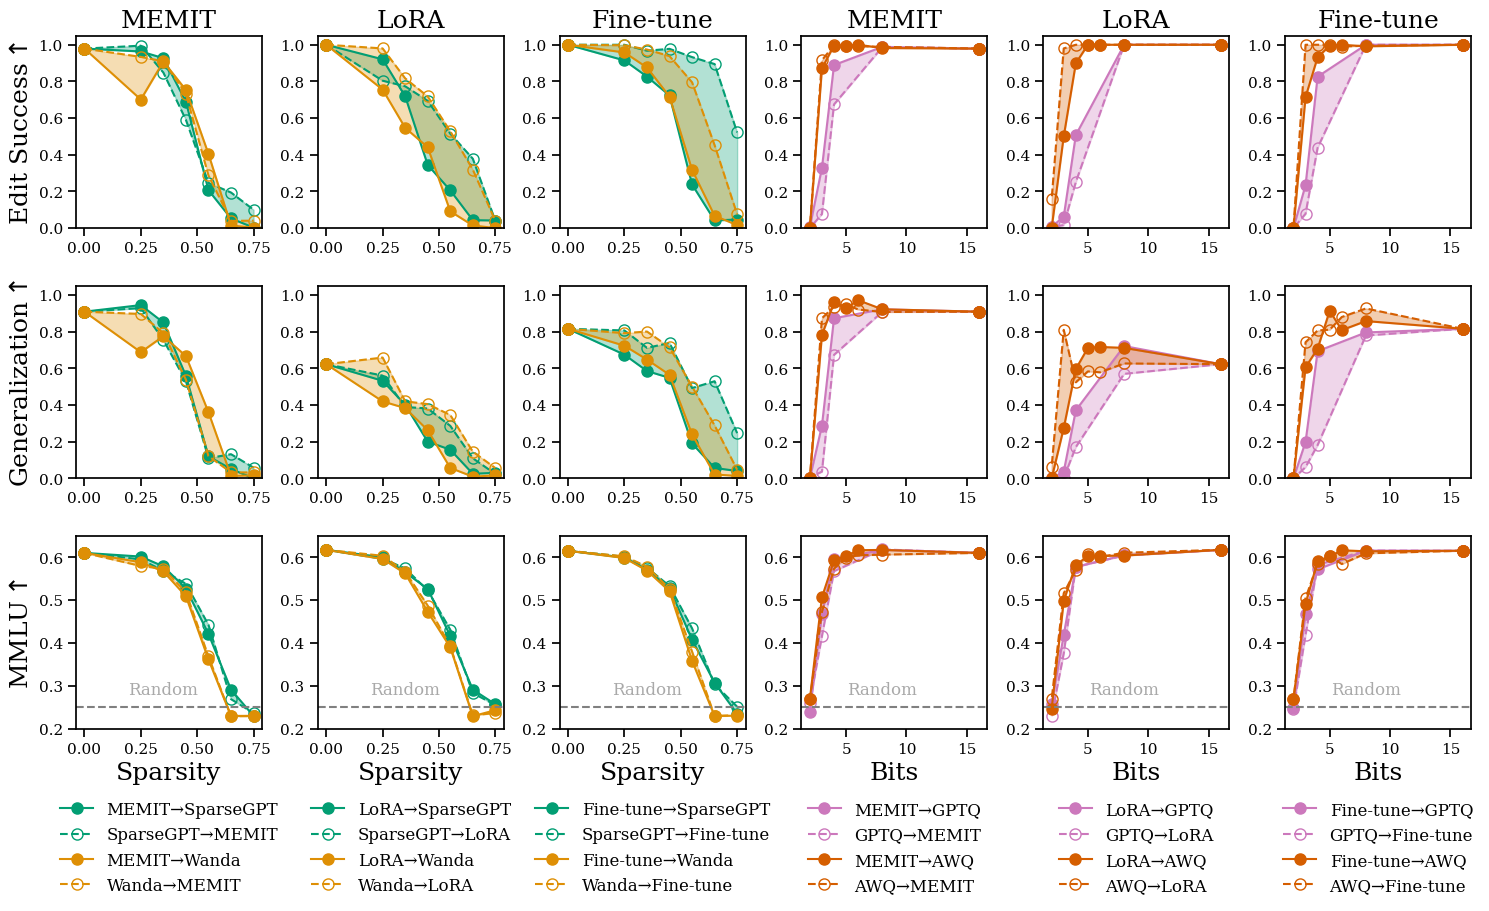

In [22]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

# 4 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(6 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "Fine-tune",
    3: "MEMIT",
    4: "LoRA",
    5: "Fine-tune"
}

compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "Fine-tune"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if row_index != 2:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")
            if col_index < 3:
                ax.text(0.35, 0.28, "Random", color="darkgray", ha="center")
            else:
                ax.text(8, 0.28, "Random", color="darkgray", ha="center")

        if row_index == 0:
            title = column_edit_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 2:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 2:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression_with_ft.pdf", bbox_inches="tight")

## Plot: Unlearning under Compression 

In [23]:
data["unlearn"].value_counts()

unlearn
GA     67
GD     67
RMU    67
Name: count, dtype: int64

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/4018671301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/4018671301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_50041/4018671301.py

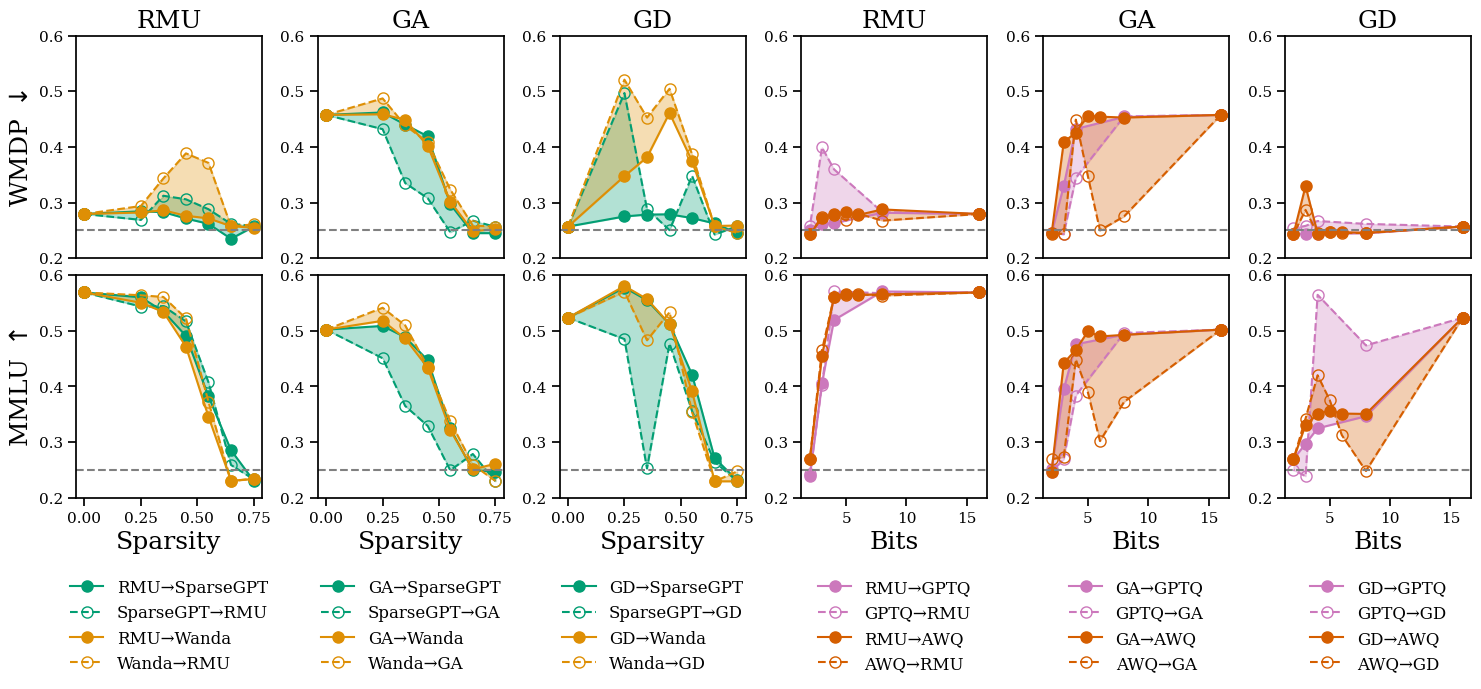

In [31]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["unlearn"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")
pruning_frame["unlearn"] = pruning_frame["unlearn"].apply(lambda x: x.upper() if x is not None else None)

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["unlearn"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["Avg WMDP"] = (quantization_frame["wmdp_bio accuracy"] + quantization_frame["wmdp_cyber accuracy"]) / 2
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")
quantization_frame["unlearn"] = quantization_frame["unlearn"].apply(lambda x: x.upper() if x is not None else None)

# 4 columns and 3 rows
fig, axes = plt.subplots(2, 6, figsize=(6 * FIG_SIZE, 2 * FIG_SIZE))
row_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
}
row_labels = {
    "Avg WMDP": r"WMDP $\downarrow$",
    "mmlu accuracy": r"MMLU $\uparrow$"
}
row_label_map = {
    0: "Avg WMDP",
    1: "mmlu accuracy"
}
column_unlearn_methods = {
    0: "RMU",
    1: "GA",
    2: "GD",
    3: "RMU",
    4: "GA",
    5: "GD",
}

compositions_by_col = {
    # RMU and WANDA + SparseGPT
    0: [("RMU→SparseGPT", "SparseGPT→RMU"), ("RMU→Wanda", "Wanda→RMU")],
    # GA and WANDA + SparseGPT
    1: [("GA→SparseGPT", "SparseGPT→GA"), ("GA→Wanda", "Wanda→GA")],
    # FT and WANDA + SparseGPT
    2: [("GD→SparseGPT", "SparseGPT→GD"), ("GD→Wanda", "Wanda→GD")],
    # RMU and GPTQ + AWQ
    3: [("RMU→GPTQ", "GPTQ→RMU"), ("RMU→AWQ", "AWQ→RMU")],
    # GA and GPTQ + AWQ
    4: [("GA→GPTQ", "GPTQ→GA"), ("GA→AWQ", "AWQ→GA")],
    # FT and GPTQ + AWQ
    5: [("GD→GPTQ", "GPTQ→GD"), ("GD→AWQ", "AWQ→GD")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["unlearn"] == column_unlearn_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["RMU", "GA", "GD"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )


        if y_metric == "Avg WMDP":
            ax.set_ylim(0.2, 0.6)
        else:
            ax.set_ylim(0.2, 0.6)

        ax.axhline(y=0.25, color="gray", linestyle="--")

        if row_index == 0:
            title = column_unlearn_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)

            # remove x ticks
            ax.set_xticks([])
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[list(row_labels.keys())[row_index]], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 1:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 1:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE * 0.25)
plt.savefig("figures/main_results_unlearn_compression_with_ga.pdf", bbox_inches="tight")